# Importacion de librerias y conexión

In [30]:
import mysql.connector
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime
from rapidfuzz import fuzz
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# CARPETA = r"C:\Users\Usuario\Desktop\E19\ProjecteData\Equip_19\Data\INE"

CARPETA = r"C:\Users\irene\Desktop\DataAnalytics\Bootcamp\Simulacro empresarial\ProjecteData\Equip_19\Data\INE"

# --------------------------
# Funciones
# --------------------------
def extraer_año(nombre):
    import re
    m = re.search(r'(\d{4})', nombre)
    return int(m.group(1)) if m else None

def renombrar_columnas_criticas(df):
    """
    Unifica nombres de columnas críticas sin tocar los valores.
    """
    col_map = {}
    for c in df.columns:
        cn = str(c).lower().strip()
        if "provinc" in cn:
            col_map[c] = "provincia"
        elif "país de residencia" in cn or "pais de residencia" in cn or ("pais" in cn and "resid" in cn):
            col_map[c] = "pais_residencia"
        elif "mes" in cn:
            col_map[c] = "mes"
        elif "total" in cn or "viajer" in cn or "pernoct" in cn:
            col_map[c] = "total"
    df = df.rename(columns=col_map)
    return df

def leer_csv(ruta):
    for enc in ["utf-8", "utf-8-sig", "latin1", "cp1252"]:
        try:
            df = pd.read_csv(ruta, sep=";", encoding=enc, engine="python")
            # Normalizar miles con coma a float
            for col in df.columns:
                if df[col].dtype == object:
                    df[col] = df[col].str.replace(".", "", regex=False)\
                                     .str.replace(",", ".", regex=False)
            return df
        except:
            continue
    raise ValueError(f"No se pudo leer {ruta}")

# --------------------------
# 1) PROCESAR APARTAMENTOS
# --------------------------

apart_viaj = []
apart_perno = []

for archivo in os.listdir(CARPETA):
    ruta = os.path.join(CARPETA, archivo)
    if not archivo.lower().endswith(".csv"):
        continue
    anio = extraer_año(archivo)
    df = leer_csv(ruta)
    df = renombrar_columnas_criticas(df)
    df["año"] = anio

    # viajeros
    if "apartamentos_viajeros" in archivo.lower():
        apart_viaj.append(df)

    # pernoctaciones (total por país)
    if "apartamentos_pernoctaciones" in archivo.lower():
        apart_perno.append(df)

# ---- unir viajeros ----
df_apart_viaj = pd.concat(apart_viaj, ignore_index=True) if apart_viaj else None
if df_apart_viaj is not None:
    df_apart_viaj["total_viajeros"] = pd.to_numeric(df_apart_viaj["total"], errors="coerce")

# ---- unir pernoctaciones ----
df_apart_perno = pd.concat(apart_perno, ignore_index=True) if apart_perno else None
if df_apart_perno is not None:
    df_apart_perno["pernoctaciones"] = pd.to_numeric(df_apart_perno["total"], errors="coerce")

# Unificar categoría extranjeros/no residentes en España:
mapeo_correccion = {'No residentes en España': 'Extranjeros'}
df_apart_viaj ['pais_residencia'] = df_apart_viaj ['pais_residencia'].replace(mapeo_correccion)


# ---- MERGE FINAL ----
df_final = df_apart_viaj.merge(
    df_apart_perno[["año","mes","provincia","pais_residencia","pernoctaciones"]],
    on=["año","mes","provincia","pais_residencia"],
    how="left"
)


df_final = df_final[["año","mes","provincia","pais_residencia",
                     "pernoctaciones","total_viajeros"]]

# --------------------------
# 2) Ajuste: coherencia viajeros/pernoctaciones
# --------------------------
df_final.loc[df_final["total_viajeros"] == 0, "pernoctaciones"] = 0

# --------------------------
# 3) Nueva columna: media de pernoctaciones por viajero
# --------------------------
df_final["media_pernoctaciones"] = df_final.apply(
    lambda row: round(row["pernoctaciones"] / row["total_viajeros"], 2)
    if row["total_viajeros"] > 0 else 0,
    axis=1
)

# --------------------------
# 4) Resultado
# --------------------------

# print(df_final.head(20))

df_final['pais_residencia'].value_counts()

pais_residencia
Total                           588
Extranjeros                     588
Alemania                        588
Bélgica                         588
Austria                         588
Finlandia                       588
Dinamarca                       588
Irlanda                         588
Italia                          588
Francia                         588
Grecia                          588
Luxemburgo                      588
Países Bajos                    588
Portugal                        588
Polonia                         588
Suiza                           588
Resto de Europa                 588
Reino Unido                     588
Republica Checa                 588
Suecia                          588
Resto de la UE                  588
Noruega                         588
Rusia                           588
Países Africanos                588
Resto del mundo                 588
Estados Unidos                  588
Resto de América                588
Residentes e

In [32]:
df_final.isnull().sum()

año                        0
mes                        0
provincia                  0
pais_residencia            0
pernoctaciones          2407
total_viajeros          1986
media_pernoctaciones     423
dtype: int64

## Tratamiento de nulos

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17052 entries, 0 to 17051
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   año                   17052 non-null  int64  
 1   mes                   17052 non-null  object 
 2   provincia             17052 non-null  object 
 3   pais_residencia       17052 non-null  object 
 4   pernoctaciones        14645 non-null  float64
 5   total_viajeros        15066 non-null  float64
 6   media_pernoctaciones  16629 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 932.7+ KB


In [34]:
# 1. Imputar 0 en total_viajeros donde falte
df_final["total_viajeros"] = pd.to_numeric(df_final["total_viajeros"], errors="coerce").fillna(0)

# 2. Forzar pernoctaciones = 0 si total_viajeros == 0 (evita medias proyectadas sin viajeros)
df_final["pernoctaciones"] = pd.to_numeric(df_final["pernoctaciones"], errors="coerce")
df_final.loc[df_final["total_viajeros"] == 0, "pernoctaciones"] = 0

In [35]:
df_final.isnull().sum()

año                       0
mes                       0
provincia                 0
pais_residencia           0
pernoctaciones          423
total_viajeros            0
media_pernoctaciones    423
dtype: int64

In [36]:
# Filtrar las filas con pernoctaciones nulas
nulos_perno = df_final[df_final["media_pernoctaciones"].isna()]

# Mostrar cuántos son y sus detalles
print("Número de nulos en media:", len(nulos_perno))
print(nulos_perno[["año","mes","provincia","pais_residencia", "pernoctaciones", "total_viajeros", "media_pernoctaciones"]])

Número de nulos en media: 423
        año         mes             provincia pais_residencia  pernoctaciones  \
24     2015       Enero        Balears. Illes     Extranjeros             NaN   
25     2015     Febrero        Balears. Illes     Extranjeros             NaN   
26     2015       Marzo        Balears. Illes     Extranjeros             NaN   
27     2015       Abril        Balears. Illes     Extranjeros             NaN   
28     2015        Mayo        Balears. Illes     Extranjeros             NaN   
...     ...         ...                   ...             ...             ...   
11864  2019  Septiembre  46 Valencia/València     Extranjeros             NaN   
11865  2019     Octubre  46 Valencia/València     Extranjeros             NaN   
11866  2019   Noviembre  46 Valencia/València     Extranjeros             NaN   
11867  2019   Diciembre  46 Valencia/València     Extranjeros             NaN   
12106  2019   Noviembre  46 Valencia/València           Rusia             NaN  

In [37]:
# 1) Rellenar pernoctaciones con total_viajeros en las filas donde está NaN
df_final.loc[
    (df_final["pernoctaciones"].isna()) & (df_final["total_viajeros"] > 0),
    "pernoctaciones"
] = df_final.loc[
    (df_final["pernoctaciones"].isna()) & (df_final["total_viajeros"] > 0),
    "total_viajeros"
]

# 2) Si aún quedan NaN (ej. sin viajeros), poner 0
df_final.loc[df_final["pernoctaciones"].isna(), "pernoctaciones"] = 0

# 3) Recalcular la media de pernoctaciones por viajero con redondeo a 2 decimales
df_final["media_pernoctaciones"] = df_final.apply(
    lambda row: round(row["pernoctaciones"] / row["total_viajeros"], 2)
    if row["total_viajeros"] > 0 else 0,
    axis=1
)

# 4) Comprobar si aún quedan nulos
print("Nulos restantes en pernoctaciones:", df_final["pernoctaciones"].isna().sum())
print("Nulos restantes en media:", df_final["media_pernoctaciones"].isna().sum())

Nulos restantes en pernoctaciones: 0
Nulos restantes en media: 0


In [38]:
# --------------------------
# Filtrar filas incoherentes: viajeros = 0 y pernoctaciones > 0
# --------------------------

# Filtrar las filas problemáticas
incoherentes = df_final[
    (df_final["total_viajeros"] == 0) &
    (df_final["pernoctaciones"] > 0)
]

# Mostrar resultado
print(f"Filas incoherentes encontradas: {len(incoherentes)}")
print(incoherentes.head(20))

Filas incoherentes encontradas: 0
Empty DataFrame
Columns: [año, mes, provincia, pais_residencia, pernoctaciones, total_viajeros, media_pernoctaciones]
Index: []


## Estandarización de texto

In [39]:
datosp = sorted([str(x) for x in df_final["provincia"].unique()])

for i in range(len(datosp)):
    for j in range(i+1, len(datosp)):
        score = fuzz.ratio(datosp[i], datosp[j])
        if score > 85:
            print(f"{score:.1f}% - '{datosp[i]}' vs '{datosp[j]}'")


90.3% - '07 Balears. Illes' vs 'Balears. Illes'
85.7% - '08 Barcelona' vs 'Barcelona'
86.5% - '46 Valencia/València' vs 'Valencia/Valéncia'


In [40]:
df_final["provincia"] = df_final["provincia"].replace(['Balears. Illes', '07 Balears. Illes'], 'Islas Baleares').replace('08 Barcelona', 'Barcelona').replace([
    "46 Valencia/València","Valencia/València","Valencia/Valéncia"], "Valencia").replace('17 Girona', 'Girona').replace('28 Madrid', 'Madrid').replace(
        '41 Sevilla', 'Sevilla').replace('29 Málaga', 'Málaga')

In [41]:
df_final["provincia"].unique()

array(['Islas Baleares', 'Barcelona', 'Girona', 'Madrid', 'Málaga',
       'Sevilla', 'Valencia'], dtype=object)

In [42]:
df_final.columns

Index(['año', 'mes', 'provincia', 'pais_residencia', 'pernoctaciones',
       'total_viajeros', 'media_pernoctaciones'],
      dtype='object')

In [43]:
datosp = sorted([str(x) for x in df_final["pais_residencia"].unique()])

for i in range(len(datosp)):
    for j in range(i+1, len(datosp)):
        score = fuzz.ratio(datosp[i], datosp[j])
        if score > 85:
            print(f"{score:.1f}% - '{datosp[i]}' vs '{datosp[j]}'")

96.3% - 'Unión Europea (sin España)' vs 'Unión Europea27 (sin España)'


In [44]:
df_final["pais_residencia"] = df_final["pais_residencia"].replace({
    "Países Africanos": "Países africanos",
    "Republica Checa": "República Checa",
    "Residentes en España": "España",
    "Españoles": "España",
    "Unión Europea27 (sin España)": "Unión Europea (sin España)"
})

In [45]:
df_final["pais_residencia"].unique()

array(['Total', 'España', 'Extranjeros', 'Unión Europea (sin España)',
       'Alemania', 'Austria', 'Bélgica', 'Dinamarca', 'Finlandia',
       'Francia', 'Grecia', 'Irlanda', 'Italia', 'Luxemburgo',
       'Países Bajos', 'Polonia', 'Portugal', 'Reino Unido',
       'República Checa', 'Suecia', 'Resto de la UE', 'Noruega', 'Rusia',
       'Suiza', 'Resto de Europa', 'Estados Unidos', 'Resto de América',
       'Países africanos', 'Resto del mundo'], dtype=object)

In [46]:
dict_mes = {
    'Abril':4 , 'Agosto':8, 'Diciembre':12, 'Enero':1, 'Febrero':2,
    'Julio':7, 'Junio':6, 'Marzo':3, 'Mayo':5, 'Noviembre':11,
    'Octubre':10, 'Septiembre':9
}

df_final["mes_numero"] = df_final["mes"].map(dict_mes)

df_final["fecha"] = pd.to_datetime(
    {"year": df_final["año"], "month": df_final["mes_numero"], "day": 1}
)

In [47]:
df_final = df_final.drop(columns=["mes_numero"])

In [48]:
df_final

,año,mes,provincia,pais_residencia,pernoctaciones,total_viajeros,media_pernoctaciones,fecha
0,2015,Enero,Islas Baleares,Total,25933.0,3705.0,7.00,2015-01-01
1,2015,Febrero,Islas Baleares,Total,30280.0,4382.0,6.91,2015-02-01
2,2015,Marzo,Islas Baleares,Total,46156.0,6536.0,7.06,2015-03-01
3,2015,Abril,Islas Baleares,Total,226542.0,36181.0,6.26,2015-04-01
4,2015,Mayo,Islas Baleares,Total,888610.0,145473.0,6.11,2015-05-01
...,...,...,...,...,...,...,...,...
17047,2021,Agosto,Valencia,Resto del mundo,1408.0,361.0,3.90,2021-08-01
17048,2021,Septiembre,Valencia,Resto del mundo,1257.0,317.0,3.97,2021-09-01
17049,2021,Octubre,Valencia,Resto del mundo,1087.0,324.0,3.35,2021-10-01
17050,2021,Noviembre,Valencia,Resto del mundo,1279.0,361.0,3.54,2021-11-01


In [49]:
df_filtrado = df_final[
    (df_final["año"] == 2015) &
    (df_final["provincia"].str.contains("Islas Baleares", case=False, na=False))
][["año","provincia","pernoctaciones","total_viajeros"]]

df_filtrado

,año,provincia,pernoctaciones,total_viajeros
0,2015,Islas Baleares,25933.0,3705.0
1,2015,Islas Baleares,30280.0,4382.0
2,2015,Islas Baleares,46156.0,6536.0
3,2015,Islas Baleares,226542.0,36181.0
4,2015,Islas Baleares,888610.0,145473.0
...,...,...,...,...
343,2015,Islas Baleares,19505.0,3237.0
344,2015,Islas Baleares,10693.0,1916.0
345,2015,Islas Baleares,3804.0,571.0
346,2015,Islas Baleares,1277.0,240.0


In [50]:
filtro_calendario = ['Barcelona','Madrid','Valencia']
df_calendario = df_final[df_final['provincia'].isin(filtro_calendario)]
df_calendario.head(50)

,año,mes,provincia,pais_residencia,pernoctaciones,total_viajeros,media_pernoctaciones,fecha
348,2015,Enero,Barcelona,Total,104814.0,16327.0,6.42,2015-01-01
349,2015,Febrero,Barcelona,Total,104055.0,18065.0,5.76,2015-02-01
350,2015,Marzo,Barcelona,Total,118545.0,21616.0,5.48,2015-03-01
351,2015,Abril,Barcelona,Total,144725.0,30055.0,4.82,2015-04-01
352,2015,Mayo,Barcelona,Total,152121.0,31437.0,4.84,2015-05-01
353,2015,Junio,Barcelona,Total,151803.0,29298.0,5.18,2015-06-01
354,2015,Julio,Barcelona,Total,143385.0,32606.0,4.40,2015-07-01
355,2015,Agosto,Barcelona,Total,157123.0,31825.0,4.94,2015-08-01
356,2015,Septiembre,Barcelona,Total,167455.0,31692.0,5.28,2015-09-01
357,2015,Octubre,Barcelona,Total,157169.0,30323.0,5.18,2015-10-01


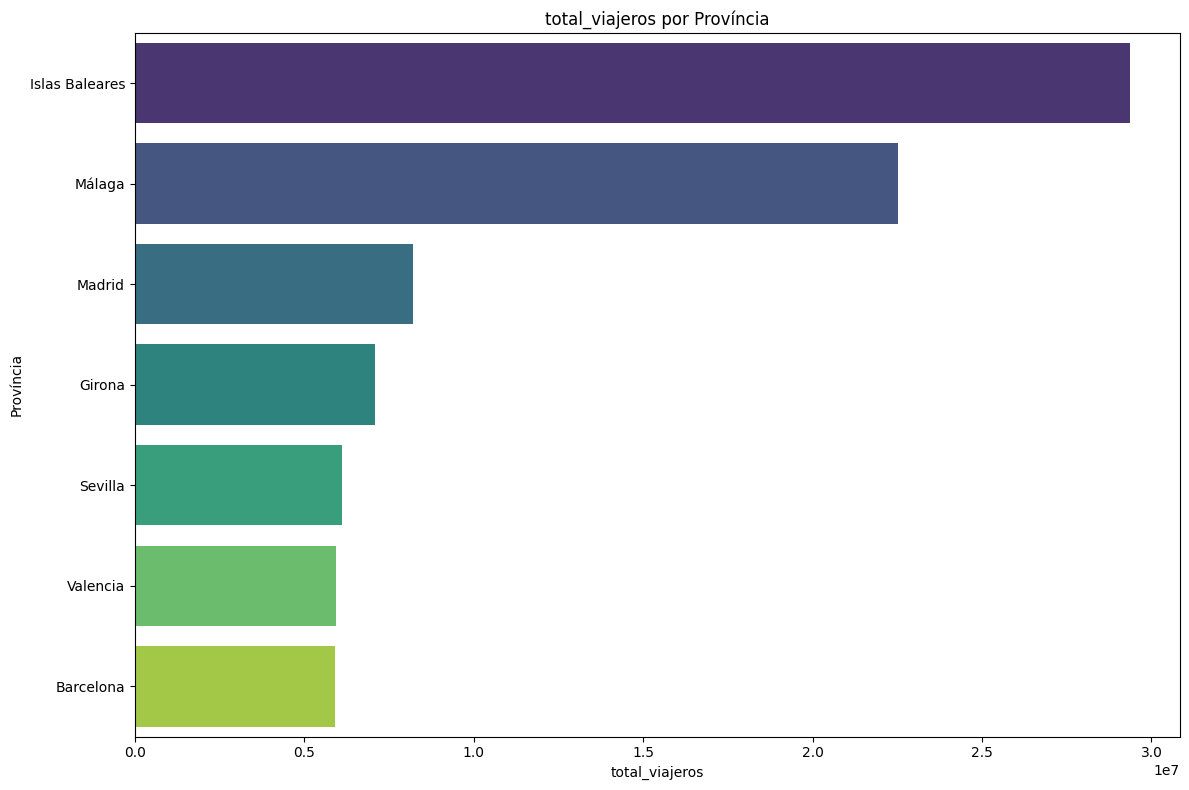

In [51]:
import seaborn as sns

colunas_requeridas = ['provincia', 'pais_residencia', 'pernoctaciones', 'total_viajeros']
for col in colunas_requeridas:
    if col not in df_final.columns:
        print(f"Erro: Coluna '{col}' não encontrada no df_final.")

# Gráfico 1: Distribuição de Pernoctações por Província
pernoctaciones_por_provincia = df_final.groupby('provincia')['total_viajeros'].sum().reset_index()
pernoctaciones_por_provincia = pernoctaciones_por_provincia.dropna(subset=['total_viajeros'])
pernoctaciones_por_provincia['total_viajeros'] = pd.to_numeric(pernoctaciones_por_provincia['total_viajeros'], errors='coerce')
pernoctaciones_por_provincia = pernoctaciones_por_provincia.dropna(subset=['total_viajeros'])
pernoctaciones_por_provincia = pernoctaciones_por_provincia.sort_values(by='total_viajeros', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=pernoctaciones_por_provincia, x='total_viajeros', y='provincia', palette='viridis')
plt.title('total_viajeros por Província')
plt.xlabel('total_viajeros')
plt.ylabel('Província')
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

## Exportacion de csv

In [52]:
df_final.to_csv('datos_INE_consolidados_17112025.csv', index=False)

___________________________________________

__________________________________________________________